In [ ]:
# Project setup - paths relative to repository root
import sys
from pathlib import Path

# Set up project paths
PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

# Add src to path for imports
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

import os, glob
from utils import (prepare_sequences, 
                   add_temporal_features, 
                   cv_leave_one_out_split,
                   create_feature_combinations,
                   get_temporal_feature_names,
                   create_optuna_objective,
                   get_date_stats,
                   custom_error_matrix,
                   custom_f1_score,
                   plot_scatter_doys,
                   calculate_mape_and_offset
                   )
from management import remove_close_mowing

import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error, root_mean_squared_error, make_scorer
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [5]:
def objective(trial):
    # --- Definícia hyperparametrov ---
    n_estimators = trial.suggest_int("n_estimators", 200, 600, step=100)
    max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10, step=2)
    max_leaf_nodes = trial.suggest_categorical("max_leaf_nodes", [None, 50, 100, 200, 500])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        max_leaf_nodes=max_leaf_nodes,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    # --- Cross-val F1 scoring ---
    scores = cross_val_score(model, X_train, y_train, cv=2, scoring=make_scorer(f1_score), n_jobs=-1)
    return scores.mean()

# Model training

In [ ]:
# Load management events reference data
points = gpd.read_file(DATA_DIR / 'train' / 'GMI_Long.gpkg')

s2_paths = glob.glob(str(DATA_DIR / 'train' / 'S2' / '*.csv'))

# Define columns to load
input_id_cols = ['PLOTID', 'Date']


s2_cols = [
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3',
    'swir1', 'swir2', 'ndvi', 'spatial_max',
    'ndvi_texture_sd_3', 'ndvi_texture_sd_5'
] + input_id_cols
input_variables = [
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3',
    'swir1', 'swir2', 'ndvi', 'spatial_max',
    'ndvi_texture_sd_3', 'ndvi_texture_sd_5']
# Get list of plot IDs
PLOTIDS = sorted(list(points['PLOTID'].unique()))

print(f"Total plots: {len(PLOTIDS)}")
print(f"Total management events: {len(points)}")
print(f"\nManagement event types:")
print(points['type'].value_counts())

In [35]:
# 2. Load and Procces data
split_col = 'id'
id_cols = ['PLOTID', 'Date', 'year', 'mowing', 'id']
plotID_col = 'PLOTID'

df = prepare_sequences(
    use_s1=False,
    points=points,
    s1_paths=None,
    s2_paths=s2_paths,
    coh_paths=None,
    s1_cols=None,
    s2_cols=s2_cols,
    coh_cols=None,
)

df = df[df['PLOTID'].isin(PLOTIDS)]

# Filter to years with management events
mask = df[['PLOTID', 'year']].apply(tuple, axis=1).isin(
    points[['PLOTID', 'year']].apply(tuple, axis=1)
)
df = df[mask]
df = df.drop(columns='grazing')
df = df[input_variables + id_cols]

df['diff_max'] = df['ndvi'] - df['spatial_max']
df['bsi'] = (
    (df["swir1"] + df["red"]) - (df["nir"] - df["blue"])
    ) / (
    (df["swir1"] + df["red"]) + (df["nir"] + df["blue"])
    )

df['doy'] = df['Date'].dt.day_of_year

# ========== 3. ADD TEMPORAL FEATURES (ONLY PAST) ==========
df = add_temporal_features(
    df=df,
    columns=input_variables+['doy', 'bsi'],
    group_cols=['PLOTID', 'year'],
    date_col='Date',
    past_steps=1
)
    
temporal_features = get_temporal_feature_names(
    base_features=input_variables+['doy', 'bsi'],
    past_steps=1,
)

model_vars = [
    'blue_diff_1', 'green_diff_1', 'red_diff_1', 'nir_diff_1', 're1_diff_1',
    're2_diff_1', 're3_diff_1', 'swir1_diff_1', 'swir2_diff_1', 'ndvi_diff_1', 'doy_diff_1', 'bsi_diff_1', 
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3', 'swir1', 'swir2', 'ndvi',  'bsi', 'diff_max', 
    'ndvi_texture_sd_5', 'ndvi_texture_sd_5_diff_1', 'ndvi_texture_sd_3', 'ndvi_texture_sd_3_diff_1'
       ]

df = df[model_vars+id_cols]
df = df.dropna(subset=model_vars)

In [36]:
# 4. Train the model
N_OPTUNA_TRIALS = 30

all_results = []
date_comparision = []
dfs_test = []

print(f"  Data shape: {df.shape}")
print(f"  Mowing events: {df['mowing'].sum()} / {len(df)} ({df['mowing'].mean()*100:.2f}%)")

# ========== 4. LEAVE-ONE-REGION-OUT CROSS-VALIDATION ==========
for test_region, df_train, df_test in cv_leave_one_out_split(df, split_col=split_col):
    
    print(f"\n  Testing on region: {test_region}")
    train_pos = df_train[df_train['mowing'] == 1]
    train_neg = df_train[df_train['mowing'] == 0].sample(len(train_pos)*32, random_state=3)
    df_train_bal = pd.concat([train_pos, train_neg])
    # Prepare train/test splits
    X_train = df_train_bal[model_vars].copy()
    y_train = df_train_bal['mowing'].copy()
    groups_train = df_train_bal[split_col].values  # Extract groups for spatial CV
    
    X_test = df_test[model_vars].copy()
    y_test = df_test['mowing'].copy()
    
    # ========== 5. HYPERPARAMETER OPTIMIZATION ==========
    print(f"  Optimizing hyperparameters using spatial CV on training regions...")
    
    # Create objective function
    objective_function = create_optuna_objective(
        X_train=X_train,
        y_train=y_train,
        groups=groups_train,  # Pass spatial groups
        cv_folds=2  # With 2 training regions, use 2-fold GroupKFold
    )
    
    # Create and run Optuna study
    study = optuna.create_study(
        direction="maximize",
        study_name=f"rf__{test_region}",
        sampler=optuna.samplers.TPESampler(seed=34)
    )
    
    study.optimize(
        objective_function,
        n_trials=N_OPTUNA_TRIALS,
        n_jobs=-1,
        show_progress_bar=False
    )
    
    best_params = study.best_trial.params
    best_cv_f1 = study.best_trial.value
    
    print(f"    Best CV F1 (training regions): {best_cv_f1:.4f}")
    print(f"    Best params: {best_params}")
    model = RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_leaf_nodes=best_params['max_leaf_nodes'],
        bootstrap=best_params['bootstrap'],
        max_samples=best_params.get('max_samples', None),
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_test)
    y_pred_bin = (y_pred >= 0.35).astype(int)
    df_test = df_test.copy()
    df_test['pred_mowing'] = y_pred_bin

    if plotID_col not in df_test.columns:
        df_test[plotID_col] = df_test['PLOTID']  # fallback: use PLOTID

    if 'doy' not in df_test.columns:
        df_test['doy'] = df_test['Date'].dt.day_of_year

    # --- Remove Close Mowing (15 days)
    df_test = df_test.groupby(['PLOTID', 'year'], group_keys=False).apply(remove_close_mowing, 'pred_mowing')

    # --- Error matrix and validation metrics ---
    metrics = custom_error_matrix(
        df_test,
        df_test['pred_mowing'],
        'mowing',
        window_after = 12
    )

    comparision, date_metrics = get_date_stats(df_test, points, df_test['pred_mowing'], 'PLOTID')

    res = (
        df_test.groupby(['PLOTID', 'year'])
        .agg(preds=('pred_mowing', 'sum'), ref=('mowing', 'sum'))
        .reset_index()[['preds', 'ref']]
    )

    mape = calculate_mape_and_offset(res['preds'], res['ref'])
    mae_nMowing = mean_absolute_error(res['preds'], res['ref'])
    mean_error_nMowing = np.mean(res['preds'] - res['ref'])
    rmse_nMowing = root_mean_squared_error(res['preds'], res['ref'])
    auc = roc_auc_score(df_test['mowing'], df_test['pred_mowing'])

    # --- Save results ---
    all_results.append({
        'test_region': test_region, #region if 'region' in locals() else None,
        'f1': metrics['F1'],
        'auc': auc,
        'precision': metrics['Precision'],
        'recall': metrics['Recall'],
        'mae_nMowing': mae_nMowing,
        'mean_error_nMowing': mean_error_nMowing,
        'rmse_nMowing': rmse_nMowing,
        'mape': mape[0],
        'mape_offset': mape[1],
        'tp': metrics['TP'],
        'fp': metrics['FP'],
        'fn': metrics['FN'],
        'tn': metrics['TN'],
        'rmse': date_metrics['RMSE'],
        'mae': date_metrics['MAE'],
        'r2': date_metrics['R²'],
        'max_error': date_metrics['Max Error'],
        'mead_deviance': date_metrics['Mean Deviance'],
        })

    date_comparision.append(comparision)
    dfs_test.append(df_test)

  Data shape: (9216, 33)
  Mowing events: 208 / 9216 (2.26%)
Leave-One-Region-Out Cross-Validation:
  Total regions: 3
  Regions: ['LR', 'NB', 'NS']
  Will perform 3 iterations (1 region held out each time)

Iteration: Test region = LR
  Train regions: ['NB', 'NS']
  Train: 5193 samples from 2 regions
  Test:  4023 samples from 1 region

  Testing on region: LR
  Optimizing hyperparameters using spatial CV on training regions...
    Best CV F1 (training regions): 0.7846
    Best params: {'n_estimators': 600, 'max_features': 'log2', 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'bootstrap': True, 'max_samples': 0.8}

Iteration: Test region = NB
  Train regions: ['LR', 'NS']
  Train: 7591 samples from 2 regions
  Test:  1625 samples from 1 region

  Testing on region: NB
  Optimizing hyperparameters using spatial CV on training regions...
    Best CV F1 (training regions): 0.7643
    Best params: {'n_estimators': 200, 'max_features': 'log2', 'min_samples_leaf': 6, 'max_leaf_nodes': 500, 

In [ ]:
X = df[model_vars]
y = df['mowing']
best_model = RandomForestClassifier(
                **best_params,
                random_state=42,
                n_jobs=-1
            )
best_model.fit(X, y)

import joblib
# Save model to outputs directory
# joblib.dump(best_model, OUTPUT_DIR / "RF_opt_vi_text_035.joblib")

# Results

In [41]:
import matplotlib as mpl

In [47]:
df_res = pd.DataFrame(all_results)
df = pd.concat(dfs_test)
df_res_test = (
        df.groupby(['PLOTID', 'year'])
        .agg(preds=('pred_mowing', 'sum'), ref=('mowing', 'sum'))
        .reset_index()[['preds', 'ref', 'year', 'PLOTID']]
    )
df_res_test['region'] = df_res_test['PLOTID'].str[0:2]

## Frequency

In [ ]:
# --- Publication settings (15.9 cm × 14.0 cm, Arial) ---
cm_to_in = 1 / 2.54
fig_w, fig_h = 15.9 * cm_to_in, 14.0 * cm_to_in

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 10,
})

# ====================================================
# Shared region list + color mapping (A and B identical)
# ====================================================
regions = sorted(df_res["test_region"].unique())
palette = sns.color_palette("Set2", n_colors=len(regions))
region_colors = dict(zip(regions, palette))

# ====================================================
# Create 2×3 layout
# ====================================================
fig, axes = plt.subplots(2, 3, figsize=(fig_w, fig_h), sharex=False)

# ====================================================
# A) Metrics per test region
# ====================================================
metrics_A = [
    (df_res.set_index("test_region").reindex(regions)["mean_error_nMowing"].values, "ME"),
    (df_res.set_index("test_region").reindex(regions)["mae_nMowing"].values, "MAE"),
    (df_res.set_index("test_region").reindex(regions)["rmse_nMowing"].values, "RMSE"),
]

for ax, (values, ylabel) in zip(axes[0], metrics_A):
    mean_val = float(np.mean(values))

    ax.bar(
        regions,
        values,
        color=[region_colors[r] for r in regions],
        edgecolor=[region_colors[r] for r in regions],
        linewidth=0.6
    )

    ax.hlines(
        y=mean_val,
        xmin=-0.4,
        xmax=len(regions) - 0.6,
        linestyles=":",
        linewidth=1.5,
        color="black",
        label=f"Mean = {mean_val:.2f}"
    )

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Test region")
    ax.grid(axis="y", linestyle=":", alpha=0.6, linewidth=0.6)
    ax.tick_params(axis="x", rotation=0)
    ax.legend(loc="lower right", frameon=True, fancybox=True, framealpha=0.2, handlelength=1.5)

# Panel label A
axes[0, 0].text(
    -0.15, 1.15, "A",
    transform=axes[0, 0].transAxes,
    fontsize=12, fontweight="bold",
    va="top", ha="left"
)

# ====================================================
# B) Metrics per year × region (grouped bars)
# ====================================================
df_metrics = (
    df_res_test.assign(err=lambda d: d["preds"] - d["ref"])
    .groupby(["region", "year"], as_index=False)
    .agg(
        ME=("err", "mean"),
        MAE=("err", lambda x: np.mean(np.abs(x))),
        RMSE=("err", lambda x: np.sqrt(np.mean(x**2))),
    )
)

years = sorted(df_metrics["year"].unique())
regions_B = sorted(df_metrics["region"].unique())

# Ensure B uses the same region order/colors as A; append any extra regions if present
regions_all = list(regions)
for r in regions_B:
    if r not in region_colors:
        regions_all.append(r)

# Rebuild mapping if B has extra regions not in A (keeps A ordering first)
palette_all = sns.color_palette("Set2", n_colors=len(regions_all))
region_colors = dict(zip(regions_all, palette_all))

x = np.arange(len(years))
bar_w = 0.2

metric_cols = [
    ("ME", r"ME ($\times 10^{-1}$)"),
    ("MAE", "MAE"),
    ("RMSE", "RMSE"),
]

handles, labels = [], []

for ax, (mcol, ylabel) in zip(axes[1], metric_cols):
    for i, reg in enumerate(regions_all):
        vals = (
            df_metrics[df_metrics["region"] == reg]
            .set_index("year")
            .reindex(years)[mcol]
            .values
        )

        # If region not present in df_metrics, skip plotting
        if np.all(np.isnan(vals)):
            continue

        bars = ax.bar(
            x + (i - (len(regions_all) - 1) / 2) * bar_w,
            vals,
            width=bar_w,
            color=region_colors[reg],
            edgecolor=region_colors[reg],
        )

        if ax is axes[1, 0]:
            handles.append(bars[0])
            labels.append(reg)

    ax.set_ylabel(ylabel)
    ax.set_xlabel("Year")
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.grid(axis="y", linestyle=":", alpha=0.6, linewidth=0.6)

# Panel label B
axes[1, 0].text(
    -0.15, 1.15, "B",
    transform=axes[1, 0].transAxes,
    fontsize=12, fontweight="bold",
    va="top", ha="left"
)

# ====================================================
# Single legend above all subplots (regions)
# ====================================================
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=len(labels),
    frameon=False,
    bbox_to_anchor=(0.5, 0.985)
)

sns.despine()
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(OUTPUT_DIR / 'frequency_comparision.png', dpi=300, bbox_inches="tight")
plt.show()

## Timing

In [61]:
date_df = pd.concat(date_comparision)

In [ ]:
# --- Publication settings (15.9 cm × 14.0 cm, Arial) ---
cm_to_in = 1 / 2.54
fig_w, fig_h = 15.9 * cm_to_in, 15.9 * cm_to_in

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 10,
})

def plot_scatter_doys_from_pairs(
    df_pairs: pd.DataFrame,
    plotID_col: str = "PLOTID",
    doy_pred_col: str = "doy_x",   # predicted DOY
    doy_ref_col: str = "doy_y",    # reference DOY
    event_col: str = "mowing_event",
    tolerance_before: int = 3,
    tolerance_after: int = 20,
    xlim: tuple[int, int] = (110, 310),
    ylim: tuple[int, int] = (110, 310),
    save_path: str = "ML_bestModel_DOY_scatter",
) -> pd.DataFrame:
    """
    Scatter plot: Reference DOY (x-axis) vs Predicted DOY (y-axis) from an already-prepared
    paired table that contains columns like:
      [PLOTID, year, doy_x, pred, mowing_event, doy_y, mowing]

    True/False classification is based on whether the reference DOY lies within:
      [doy_x - tolerance_before, doy_x + tolerance_after]

    Markers:
      - 'o' for True (within tolerance)
      - 'X' for False (outside tolerance)

    Colors:
      - by mowing_event (0=1st mowing, 1=2nd mowing, ...)

    Returns
    -------
    pd.DataFrame
        Copy of df_pairs used for plotting, with an added column 'prediction' in {'TP','FP'}.
    """
    # ---- Validate / copy ----
    required = {plotID_col, "year", doy_pred_col, doy_ref_col, event_col}
    missing = required - set(df_pairs.columns)
    if missing:
        raise ValueError(f"df_pairs is missing required columns: {sorted(missing)}")

    df_plot = df_pairs.copy()

    # Keep only rows where both DOYs exist (a point on scatter needs both)
    df_plot = df_plot[pd.notna(df_plot[doy_pred_col]) & pd.notna(df_plot[doy_ref_col])].copy()

    # Ensure numeric
    df_plot[doy_pred_col] = pd.to_numeric(df_plot[doy_pred_col], errors="coerce")
    df_plot[doy_ref_col] = pd.to_numeric(df_plot[doy_ref_col], errors="coerce")
    df_plot[event_col] = pd.to_numeric(df_plot[event_col], errors="coerce").astype("Int64")

    df_plot = df_plot.dropna(subset=[doy_pred_col, doy_ref_col, event_col]).copy()
    df_plot[event_col] = df_plot[event_col].astype(int)

    # ---- Classify True/False (TP/FP) ----
    within = (
        (df_plot[doy_ref_col] >= (df_plot[doy_pred_col] - tolerance_before))
        & (df_plot[doy_ref_col] <= (df_plot[doy_pred_col] + tolerance_after))
    )
    df_plot["prediction"] = np.where(within, "TP", "FP")

    # ---- Plot ----
    sns.set_theme(style="white")

    # Use publication figure size
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    # Limits for reference lines based on plotted data
    mins = min(df_plot[[doy_pred_col, doy_ref_col]].min().min(), xlim[0], ylim[0])
    maxs = max(df_plot[[doy_pred_col, doy_ref_col]].max().max(), xlim[1], ylim[1])
    doy_limits = [mins - 5, maxs + 5]

    # 1:1 and tolerance boundaries
    ax.plot(doy_limits, doy_limits, color="black", linestyle="-", linewidth=1, label="1:1 line")
    ax.plot(
        doy_limits,
        [x + tolerance_before for x in doy_limits],
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"+{tolerance_before} days",
    )
    ax.plot(
        doy_limits,
        [x - tolerance_after for x in doy_limits],
        color="black",
        linestyle="--",
        linewidth=1,
        label=f"-{tolerance_after} days",
    )

    # Colors by mowing_event
    unique_events = sorted(df_plot[event_col].unique())
    palette = sns.color_palette("YlOrRd", n_colors=len(unique_events))
    color_map = {ev: palette[i] for i, ev in enumerate(unique_events)}

    # Scatter: x=reference, y=predicted
    for _, row in df_plot.iterrows():
        ax.scatter(
            row[doy_ref_col],
            row[doy_pred_col],
            color=color_map[row[event_col]],
            s=50,  # slightly reduced for publication scale
            marker="o" if row["prediction"] == "TP" else "X",
            linewidth=1.0,
            edgecolor=None,
        )

    # Labels using rcParams sizes (no manual fontsize needed)
    ax.set_xlabel("Reference DOY")
    ax.set_ylabel("Predicted DOY")

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    # Requested grid style
    ax.grid(linestyle=":", alpha=0.6, linewidth=0.6)

    # Legend: mowing_event colors + True/False markers
    event_handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=color_map[ev],
            markeredgecolor="black",
            markersize=7,
            label=f"{ev + 1}. mowing",
        )
        for ev in unique_events
    ]
    tf_handles = [
        plt.Line2D([0], [0], marker="X", color="black", linestyle="None", markersize=7, label="False"),
        plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=7, label="True"),
    ]
    ax.legend(handles=event_handles + tf_handles, loc="best", frameon=True)

    sns.despine(ax=ax)
    plt.tight_layout()
    #plt.savefig('/mnt/d/OneDrive - Univerzita Komenskeho v Bratislave/03.PhD/Projects/00_GMI/Visual/Results/test_data_cv/doy_comparision.png', dpi = 300, bbox_inches="tight")
    plt.show()

    return df_plot

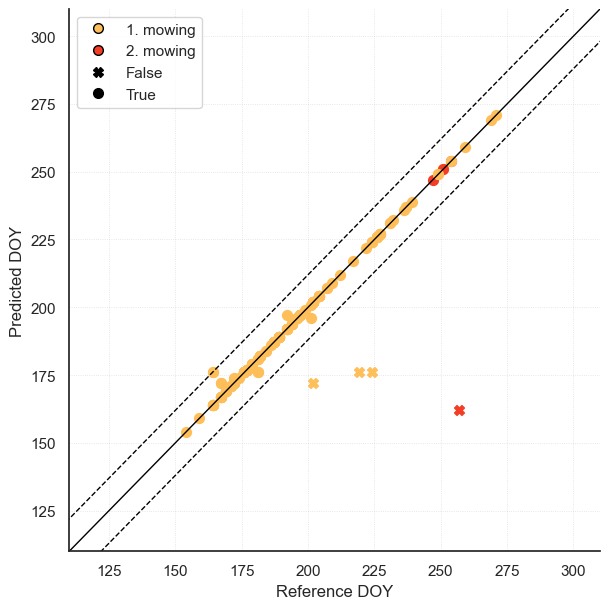

,PLOTID,year,doy_x,pred,mowing_event,doy_y,mowing,prediction
2,LR101,2022,174.0,1.0,0,174.0,1.0,TP
3,LR101,2023,189.0,1.0,0,189.0,1.0,TP
6,LR105,2023,189.0,1.0,0,189.0,1.0,TP
7,LR16,2021,197.0,1.0,0,197.0,1.0,TP
8,LR16,2022,194.0,1.0,0,194.0,1.0,TP
...,...,...,...,...,...,...,...,...
80,NS53,2022,224.0,1.0,0,224.0,1.0,TP
81,NS53,2023,189.0,1.0,0,189.0,1.0,TP
82,NS7,2021,176.0,1.0,0,219.0,1.0,FP
83,NS7,2022,186.0,1.0,0,186.0,1.0,TP


In [108]:
plot_scatter_doys_from_pairs(
    df_pairs=date_df,
    tolerance_before=12,
    tolerance_after=12
)

## Model

In [ ]:
# --- Publication settings (15.9 cm × 14.0 cm, Arial) ---
cm_to_in = 1 / 2.54
fig_w, fig_h = 15.9 * cm_to_in, 15.9 * cm_to_in

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 10,
})

def plot_rf_feature_importance(best_model, feature_names, top_n=20, figsize=(8,6), title="Random Forest Feature Importance"):
    """
    Plot feature importances from a trained RandomForest model.
    
    Parameters
    ----------
    best_model : sklearn.ensemble.RandomForestClassifier or Regressor
        Trained Random Forest model with `feature_importances_` attribute.
    feature_names : list
        Names of input features used in training.
    top_n : int
        Number of top features to display (sorted by importance).
    figsize : tuple
        Figure size for the plot.
    title : str
        Title for the plot.
    """

    # --- Extract importances ---
    importances = pd.Series(best_model.feature_importances_, index=feature_names)
    importances = importances.sort_values(ascending=False).head(top_n)

    # --- Plot ---
    plt.figure(figsize=figsize)
    sns.barplot(x=importances.values, y=importances.index, color="#636363")
    plt.ylabel("")
    plt.tight_layout()
    plt.grid(axis='x', alpha = 0.6, linewidth = 0.6)
    sns.despine()
    # plt.savefig(OUTPUT_DIR / 'featureImportance.pdf', bbox_inches="tight")
    plt.show()

plot_rf_feature_importance(best_model, feature_names=X.columns, top_n=15)

In [ ]:
# --- Publication settings (15.9 cm × 12.0 cm, Arial) ---
cm_to_in = 1 / 2.54
fig_w, fig_h = 15.9 * cm_to_in, 13.0 * cm_to_in

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": 9,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 10,
})

sns.set_style("white")

features = [
    ("bsi_diff_1",   "BSI difference (t − t−1)"),
    ("ndvi_diff_1",  "NDVI difference (t − t−1)"),
    ("diff_max",     "pNDVI difference (NDVI − pNDVI)"),
]

colors = {
    "ref":  "#7570b3",   # Set2 green
    "pred": "#66a61e"    # Set2 orange
}

fig, axes = plt.subplots(
    nrows=3, ncols=1,
    figsize=(fig_w, fig_h),
    sharex=False
)

for ax, (col, xlabel) in zip(axes, features):

    sns.histplot(
        data=df[df["mowing"] == 1],
        x=col,
        bins=40,
        stat="density",
        color=colors["ref"],
        alpha=0.45,
        edgecolor=None,
        label="Reference mowing",
        ax=ax
    )

    sns.histplot(
        data=df[df["pred_mowing"] == 1],
        x=col,
        bins=40,
        stat="density",
        color=colors["pred"],
        alpha=0.45,
        edgecolor=None,
        label="Predicted mowing",
        ax=ax
    )

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")

    # Publication-style grid (subtle)
    ax.grid(axis="y", linestyle=":", alpha=0.6, linewidth=0.6)

# ---- Single legend above the panels (2 columns) ----
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 0.995),
    handlelength=1.4,
    columnspacing=1.5
)

# Remove per-axes legends (keep only the global one)
for ax in axes:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

sns.despine()

# Leave room at the top for the legend
plt.tight_layout(h_pad=1.2, rect=[0, 0, 1, 0.96])
# plt.savefig(OUTPUT_DIR / 'feature_histogram.pdf', bbox_inches="tight")
plt.show()